In [1]:
from os.path import join as pjoin

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.signal as signal

In [2]:
def dvb_channel_filter(data: np.array, draw=False):
    cutoff = 7e6  # Pass band Frequency
    fs = 30000000  # Sampling FrequencyV
    h = signal.firwin(100, cutoff, fs=fs)
    filtered_data = signal.lfilter(h, 1.0, data)
    if draw:
        w, h = signal.freqz(h, 1.0, worN=8000)
        plt.semilogy(w / np.pi, abs(h))
        plt.title("Filter Frequency Response")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Gain")
        plt.grid(True)
        plt.show()
    return filtered_data

Load data

In [3]:
dvbt_data = sio.loadmat(pjoin("data", "dvbt.mat"))
fc = dvbt_data["fc"][0][0]
f1 = dvbt_data["f1"][0][0]
f2 = dvbt_data["f2"][0][0]
fs = dvbt_data["fs"][0][0]
data = np.squeeze(dvbt_data["data"])

# For testing purposes limit number of processed data
data = data[0:100000]
N = len(data)
n = np.linspace(-0.5, 0.5, N)

Plot fft of received data

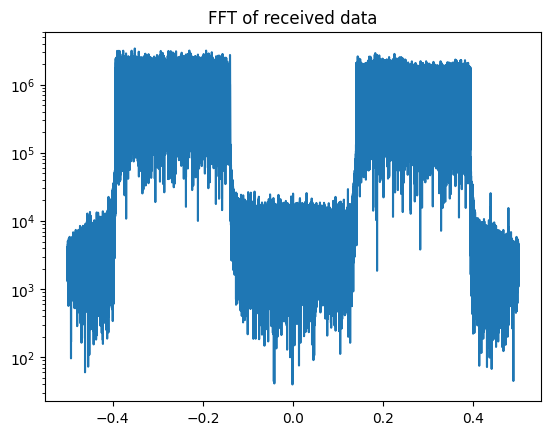

In [4]:
plt.semilogy(n, np.abs(np.fft.fftshift(np.fft.fft(data))))
plt.title("FFT of received data")
plt.show()

Mix frequencies to lower frequency of examined signal

In [5]:
fo = 8e6 / fs
k = np.arange(1, len(data) + 1)
c = np.exp(1j * (2 * np.pi * fo * k))
data_low = data * c

a = data[0] * c[0]
b = data[1] * c[1]
print(f"{data_low[0]=}\n{a=}\n{b=}\n{data[0]=}\n{c[0]=}")
a1 = np.multiply(data[0], c[0])
print(f"{a1=}")

data_low[0]=np.complex128(-64.47361705510619+77.68624526794638j)
a=np.complex128(-64.47361705510619+77.68624526794639j)
b=np.complex128(105.13460146056168+96.97791282415218j)
data[0]=np.complex128(84+56j)
c[0]=np.complex128(-0.10452846326765333+0.9945218953682734j)
a1=np.complex128(-64.47361705510619+77.68624526794638j)


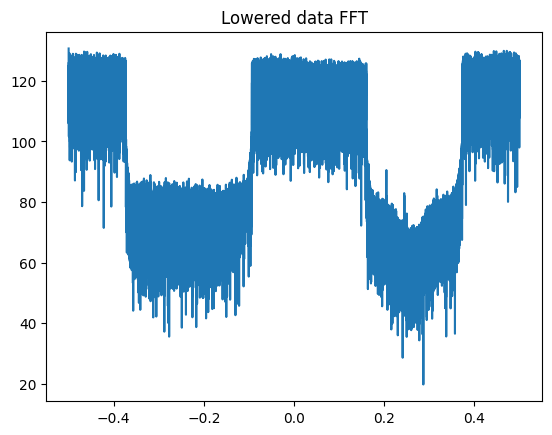

In [6]:
plt.figure()
plt.plot(n, 20 * np.log10(np.abs(np.fft.fft(data_low))))
plt.title("Lowered data FFT")
plt.show()

Filter received data

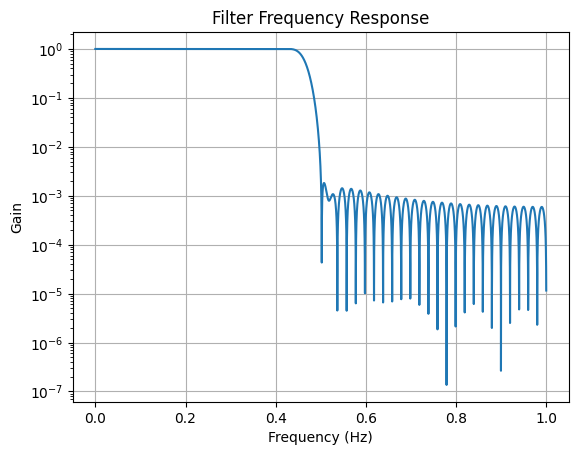

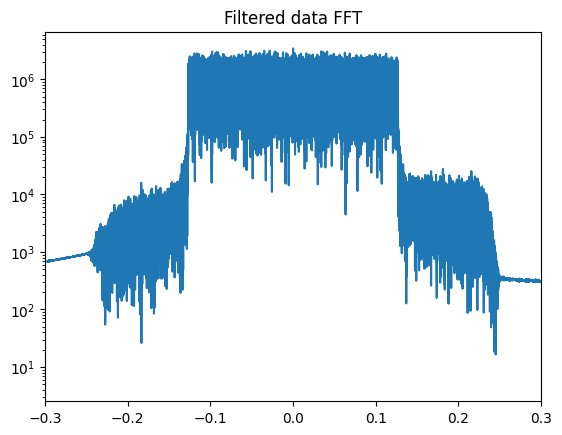

In [7]:
data_filtered = dvb_channel_filter(data_low, draw=True)
plt.figure()
plt.semilogy(n, np.abs(np.fft.fftshift(np.fft.fft(data_filtered))))
plt.title("Filtered data FFT")
plt.xlim([-0.3, 0.3])
plt.show()

Resampling

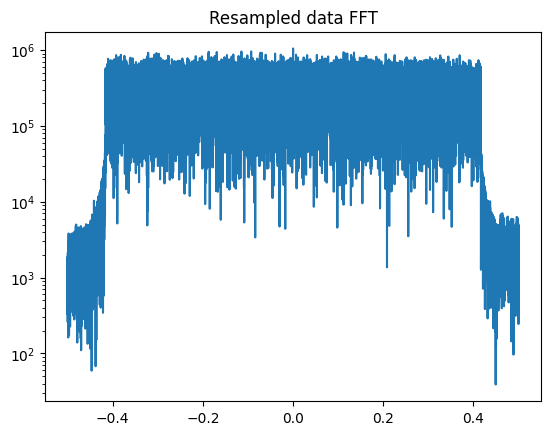

In [8]:
B = 8e6
fs_dvb = 8 / 7 * B
data_resampled = signal.resample(data_filtered, int(N * fs_dvb / fs))
# data_resampled = signal.resample_poly(data_filtered, int(fs_dvb), int(fs))
N_resampled = len(data_resampled)
n_resampled = np.linspace(-0.5, 0.5, N_resampled)
plt.figure()
plt.semilogy(n_resampled, np.abs(np.fft.fftshift(np.fft.fft(data_resampled))))
plt.title("Resampled data FFT")
plt.show()

Find symbols

In [9]:
symbol_per_block = 8192
guard_interval = 1 / 8
guard_symbols = int(symbol_per_block * guard_interval)
# frame_len = int(symbol_per_block + guard_symbols)
correlation = np.zeros(N_resampled, dtype=complex)
for i in range(N_resampled):
    if i + symbol_per_block + guard_symbols > N_resampled:
        break
    first_guard = data_resampled[i: i + guard_symbols]
    second_guard = data_resampled[
                   i + symbol_per_block: i + symbol_per_block + guard_symbols
                   ]
    corr = np.correlate(first_guard, second_guard)
    correlation[i] = corr[0]

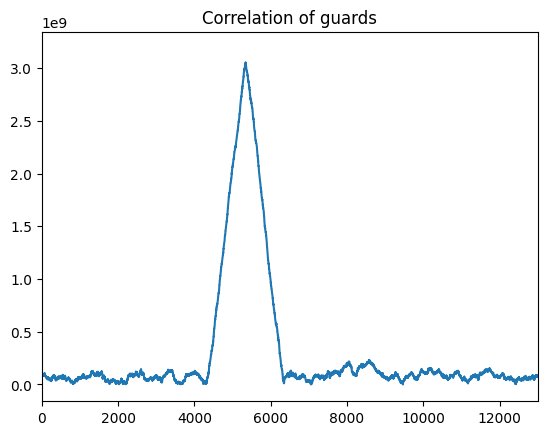

In [10]:
plt.figure()
plt.plot(np.abs(correlation))
plt.title("Correlation of guards")
plt.xlim([0000, 13000])
plt.show()

Find peaks in data source signal to find beginning of each block

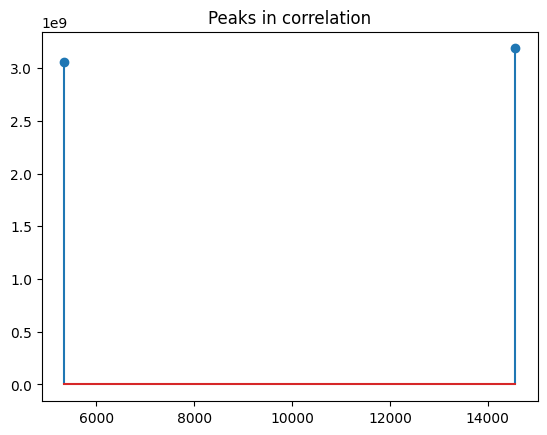

In [11]:
peaks = signal.find_peaks(np.abs(correlation), height=1e9, distance=symbol_per_block)
plt.figure()
plt.stem(peaks[0], peaks[1]["peak_heights"])
plt.title("Peaks in correlation")
plt.show()

Text(0.5, 1.0, 'Symbol po FFT')

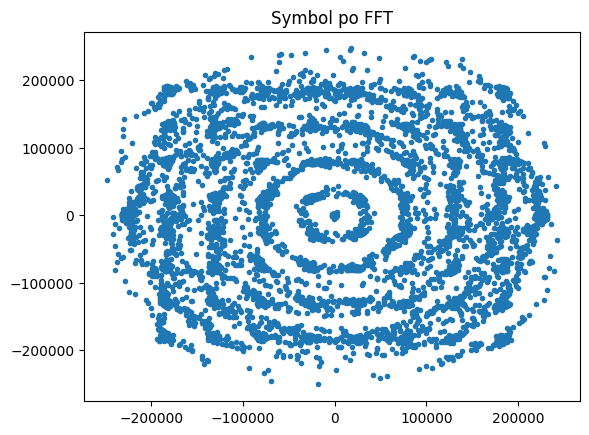

In [29]:
symbol_end = np.arange(peaks[0][0] + 1024 + 8192, len(data_resampled), 8192 + 1024, dtype=int)
data_no_guard = np.empty((len(symbol_end), 8192), dtype=complex)
for idx, val in enumerate(symbol_end):
    data_no_guard[idx] = data_resampled[val - 8192:val]

data_af_fft = np.fft.fft(data_no_guard)
# % data_af_fft = ifft(data_no_guard);
# % data_af_fft_sum = data_af_fft';
# % data_af_fft_sum = data_af_fft(:);
plt.figure()
plt.plot(data_af_fft[0].real, data_af_fft[0].imag, '.')
plt.title('Symbol po FFT')


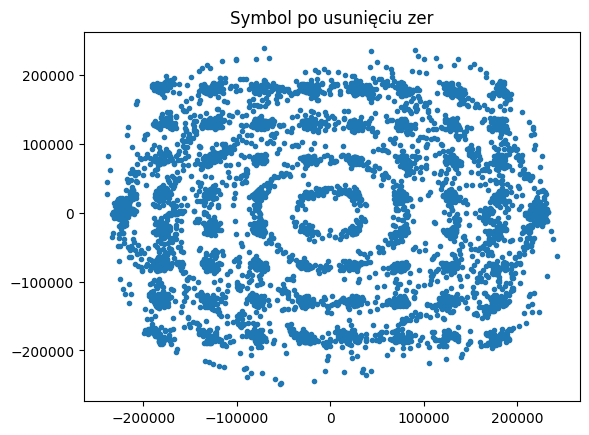

In [36]:
symbols = np.fft.fftshift(data_af_fft)
# % symbols = fftshift(data_af_fft);
symbols = symbols[:,688:]
symbols = symbols[:, 1:6816]
one_symbol = symbols[0]
plt.figure()
plt.plot(one_symbol.real, one_symbol.imag,'.')
plt.title('Symbol po usunięciu zer');

In [17]:
%connect_info

{
  "shell_port": 52327,
  "iopub_port": 44677,
  "stdin_port": 35997,
  "control_port": 49491,
  "hb_port": 56981,
  "ip": "127.0.0.1",
  "key": "6d4e6f92-efc1ebe217e334ba5251563e",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "dvbt.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-61b45302-ddbc-40bd-ba6a-a15f17dfb811.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
